<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#ОБЩИЕ-ВЫВОДЫ" data-toc-modified-id="ОБЩИЕ-ВЫВОДЫ-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ОБЩИЕ ВЫВОДЫ</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None


data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Данные выглядят красиво, кроме столбца Tenure с пропусками, а некоторые столбцы кажутся бесполезными (RowNumber, CustomerId).

Типы данных в столбцах соответствуют природе этих данных, преобразования не требуются.

In [2]:
data['Tenure'].describe() #до заполнения медианой

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [3]:
# приступим к предобработке данных
data.duplicated().sum() #дубликатов нет, отлично
data['CustomerId'].duplicated().sum()
data['Tenure'].value_counts()

# тяжело определить, какие факторы влияют на продолжительность обслуживания того или иного клиента в нашем банке.
# даже в первых пяти строках есть уходы как среди относительно новых клиентов (2 года), так и среди старых (8 лет).
# поэтому заменим пропущенные значения медианой

median_tenure = data['Tenure'].median()
median_tenure
data['Tenure'] = data['Tenure'].fillna(median_tenure)

df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns')

df.info()
df['Tenure'].describe()

#пропусков нет, типы данных в норме, предобработка окончена

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

## Исследование задачи

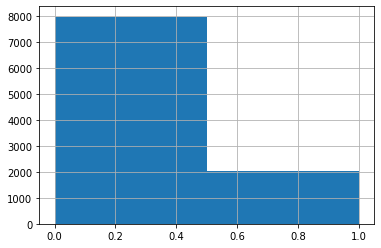

In [4]:
df['Exited'].value_counts()

df['Exited'].hist(bins=2)
plt.show()
# видим сильный дисбаланс ключевого признака

In [5]:
# разобьем данные на выборки и начнем готовить признаки

df = pd.get_dummies(df, drop_first=True)
df.info()
df.head(10)

target = df['Exited']
features = df.drop('Exited', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, train_size=0.5, random_state=12345)

print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB
(6000, 11)
(2000, 11)
(2000, 11)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [7]:
#ohe_df = ['Gender', 'Geography']
#ohe = OneHotEncoder(categories=[ohe_df], drop='first')
#ohe.fit(features_train)
#features_train = ohe.transform(features_train[ohe_df])
#features_test[ohe_df] = ohe.transform(features_test[ohe_df])
#features_valid[ohe_df] = ohe.transform(features_valid[ohe_df])


numeric = ['CreditScore', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


features_train.head() #проверяем, что масштабирование прошло как надо

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,35,8.0,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,37,8.0,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,44,3.0,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,24,6.0,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,27,2.0,1.140475,1,0,0,1.524268,1,0,0


In [8]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

F1: 0.27225130890052357
AUC-ROC: 0.7383831706070267


In [9]:
другиеmodel = RandomForestClassifier(random_state=12345, n_estimators=100)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
predicted_valid

print("F1:", f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)


F1: 0.27225130890052357
AUC-ROC: 0.7383831706070267


Кратко описываю выводы: у модели линейной регрессии на несбалансированных данных результат метрики F1 далек от целевого в 0.59. Модель случайного леса по F1 тоже не дотягивает, но по обеим метрикам результаты лучше.

## Борьба с дисбалансом

In [10]:
# самое простое - попробовать сбалансировать вес классов
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

F1: 0.4779220779220779
AUC-ROC: 0.7415132722004105


Уже получше (F1 выросла почти вдвое), но все еще есть к чему стремиться. AUC-ROC выросла несущественно.

In [11]:
# теперь попробуем upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts())

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

0    4804
1    4784
Name: Exited, dtype: int64
F1: 0.47660311958405543
AUC-ROC: 0.7415762340140704


In [12]:
model = RandomForestClassifier(random_state=12345, n_estimators=189)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

F1: 0.599476439790576
AUC-ROC: 0.8511170475106847


Апсемплинг не сильно помог логистической регрессии. А вот случайный лес благодаря апсемплингу достиг искомого порога в 0,59, хотя AUC-ROC у этой модели даже немного снизилась.

<div class="alert alert-danger">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>

**Нужно доработать** ❌: суть функции upsample — увеличить количество строк положительного класса во столько раз, чтобы избавиться от дисбаланса классов в целевом признаке и прийти к соотношению приблизительно 1:1. Как раз за это отвечает параметр `repeat`, он подбирается на основе отношения классов в целевом признаке нашей текущей выборке. Можешь перепроверить значение параметра, которое ты используешь? Также для наглядности и самоконтроля не забудь вывести соотношение классов в увеличенной выборке на экран</div>

In [13]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)


F1: 0.48007590132827316
AUC-ROC: 0.7415942231036876


Путём подбора значения frac самое большое значение, которого удалось добиться - 0,48. Всё ещё маловато. AUC-ROC держится на уровне 0,74.

In [14]:
model = RandomForestClassifier(random_state=12345, n_estimators=400)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

F1: 0.5969849246231156
AUC-ROC: 0.8479367263754534


По случайному лесу при уменьшении выборки чуть выше F1, чуть ниже AUC-ROC. 

In [15]:
# попробуем вычислить более подходящий для модели порог
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    
print(probabilities_valid)
# но, как выяснилось, я не понимаю, как этот порог применить непосредственно в модель :( 
# поэтому попробую ниже другую модель

Порог = 0.00 | Точность = 0.211, Полнота = 1.000
Порог = 0.05 | Точность = 0.230, Полнота = 0.995
Порог = 0.10 | Точность = 0.251, Полнота = 0.983
Порог = 0.15 | Точность = 0.280, Полнота = 0.967
Порог = 0.20 | Точность = 0.304, Полнота = 0.950
Порог = 0.25 | Точность = 0.336, Полнота = 0.934
Порог = 0.30 | Точность = 0.371, Полнота = 0.898
Порог = 0.35 | Точность = 0.393, Полнота = 0.844
Порог = 0.40 | Точность = 0.425, Полнота = 0.794
Порог = 0.45 | Точность = 0.472, Полнота = 0.745
Порог = 0.50 | Точность = 0.519, Полнота = 0.702
Порог = 0.55 | Точность = 0.560, Полнота = 0.643
Порог = 0.60 | Точность = 0.601, Полнота = 0.582
Порог = 0.65 | Точность = 0.649, Полнота = 0.525
Порог = 0.70 | Точность = 0.706, Полнота = 0.478
Порог = 0.75 | Точность = 0.725, Полнота = 0.404
[[0.8975 0.1025]
 [0.415  0.585 ]
 [0.8875 0.1125]
 ...
 [0.88   0.12  ]
 [0.6575 0.3425]
 [0.4525 0.5475]]


In [16]:
# закомменчу эти ячейки, так как модели перенес выше, после каждого способа борьбы с дисбалансом или без борьбы.
#model = RandomForestClassifier(random_state=12345, n_estimators=100)
#model.fit(features_train, target_train)
#predicted_valid = model.predict(features_valid)
#predicted_valid

#print(f1_score(target_valid, predicted_valid))

In [17]:
#model = RandomForestClassifier(random_state=12345, n_estimators=100)
#model.fit(features_upsampled, target_upsampled)
#predicted_valid = model.predict(features_valid)
#predicted_valid

#print(f1_score(target_valid, predicted_valid))

<div class="alert alert-warning">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: подбор порога классификации очень похож на цикл для подбора гиперпараметров, например сам код подбора будет выглядеть примерно так:
    
    best_f1 = 0
    best_threshold = 0
    model = RandomForestClassifier(...)
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    for threshold in np.arange(0, 1, 0.01):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_threshold = threshold
            best_f1 = f1
    
А использование на тестовой выборке, например, так:
    
    probabilities_one_test = model.predict_proba(features_test)[:, 1]
    predicted_test = probabilities_one_test > best_threshold
    f1_test = f1_score(target_test, predicted_test)
</div>

In [18]:
#model = RandomForestClassifier(random_state=12345, n_estimators=100)
#model.fit(features_downsampled, target_downsampled)
#predicted_valid = model.predict(features_valid)
#predicted_valid

#print(f1_score(target_valid, predicted_valid))

При ап- и даунсемплинге случайный лес показывает необходимый нам результат выше 0.59. Проверим теперь на тестовой выборке.

## Тестирование модели

In [19]:
#model = RandomForestClassifier(random_state=12345, n_estimators=400)
#model.fit(features_downsampled, target_downsampled)
model = RandomForestClassifier(random_state=12345, n_estimators=189)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC:", auc_roc)

F1: 0.6055776892430279
AUC-ROC: 0.8400040225261463


<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: бейзлайн побит, ура!</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: на этом этапе как раз необходимо выбрать лучшую модель и проверить ее качество на тестовой выборке, которую необходимо было выделить в начале. Тогда алгоритм в этом проекте будет примерно следующим:
1. Обучить 2 выбранные тобой модели с подбором гиперпараметров без учета борьбы с дисбалансом и зафиксировать результаты в выводах;
2. Проверить 3 разных способа борьбы с дисбалансом для каждой модели, подобрать для каждой гиперпараметры и зафиксировать результаты в выводах
3. У тебя должно получиться 8 моделей: 2 модели без учета дисбаланса и по 2 модели на каждый способ борьбы с дисбалансом. После этого нужно выбрать лучшую по F1-мере из этих моделей и проверить ее на тестовой выборке. Необходимое значение F1 для принятия проекта >=0.59</div>

### ОБЩИЕ ВЫВОДЫ
Мы поработали с данными об уходе клиентов «Бета-Банка», чтобы построить модель, которая помогла бы сохранять текущих клиентов, так как это для компании обходилось бы дешевле, чем привлекать новых. Для этого изучили данные по 10 000 прошлых клиентов, из которых порядка 20% от услуг банка ранее отказались. Провели предобработку данных, после чего приступили к исследованию задачи. Проанализировали модели без учёта дисбаланса, результаты нас не устроили, поэтому стали строить модели с учётом дисбаланса. 
Оптимальной моделью стал случайный лес с апсемплингом, что подтверждается результатами тестирования на тестовой выборке (F1 = 0,61) и метрики AUC-ROC (0,84). 

<div style="padding: 20px 25px; border: 2px #6495ed solid">
    
<h2 style="color: #87187D">Итоговый комментарий ревьюера<a class="tocSkip"></a></h2>

Видно, что ты приложил много усилий, спасибо за проект!

Но тебе обязательно нужно обратить внимание на следующее:
* выдели три выборки;
* добавь расчет AUC-ROC на каждом этапе;
* перепроверь коэффициенты увеличения/уменьшения выборок;
* добавь этап тестирования лучшей модели;
    
Остальные комментарии можно найти в проекте. Готов ответить на любые вопросы :)

<b>Жду доработанный проект на повторное ревью! Удачи!</b>
        
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*